# Part 2: The Fourier Transform and the Frequency Domain

## The "recipe" for a signal

In the previous section, we discussed how signals can be composed of multiple sine waves. We can use a tool called the Fourier Transform to decompose a signal into its constituent sine waves.

Lets look at an example of a synthetic signal composed of four sine waves:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')

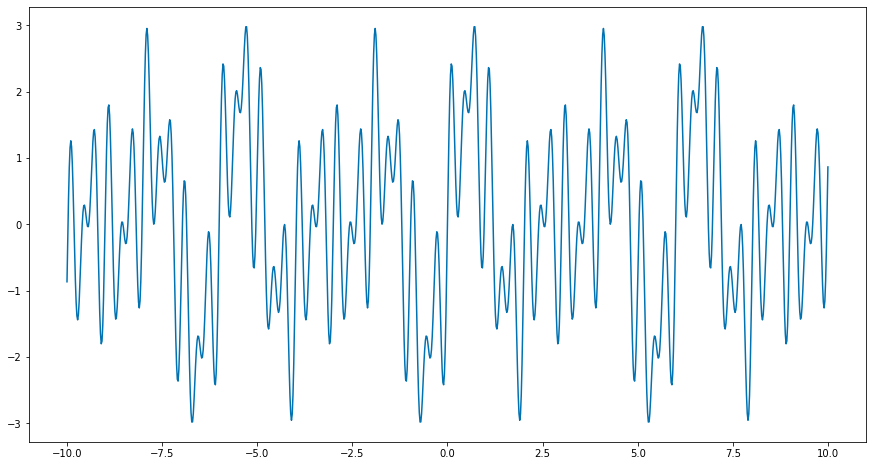

In [2]:
f = [1/3, 1/2, 2, 3]
n_samples = 1001
x = np.linspace(-10, 10, n_samples)
y = [np.sin(x * freq * (2 * np.pi)) for freq in f] 
y = np.sum(y, axis=0)

# Plot
plt.figure(figsize=(15,8))
plt.plot(x,y);

And now lets look at how we can use `scipy.fftpack.fft` (`fft` stands for "Fast Fourier Transform") to identify the individual sine wave components used to create the synthic signal:

In [3]:
from scipy.fftpack import fft, fftfreq, fftshift

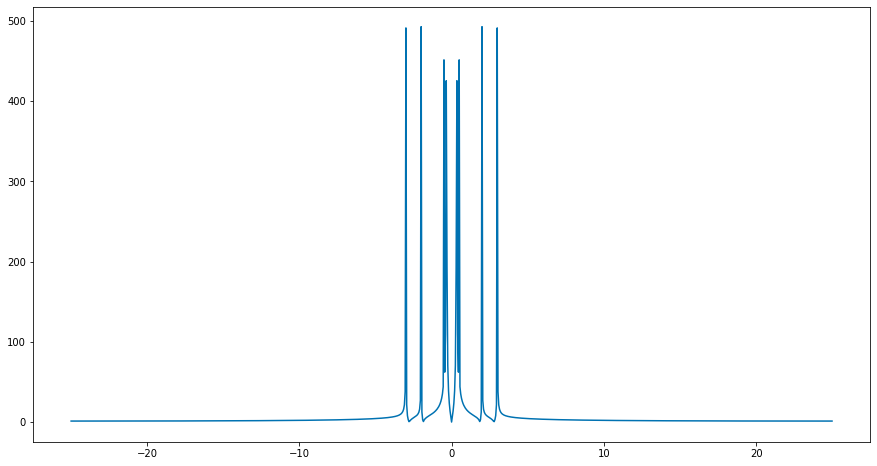

In [4]:
freq_y = fftshift(np.abs(fft(y))) # fft, with centered origin
freq_x = fftshift(fftfreq(x.size, x[1] - x[0])) # find frequencies of fft

# Plot
plt.figure(figsize=(15, 8))
plt.plot(freq_x, freq_y);

If you look carefully, you can see eight spikes in that plot. These are more obvious if you zoom in:

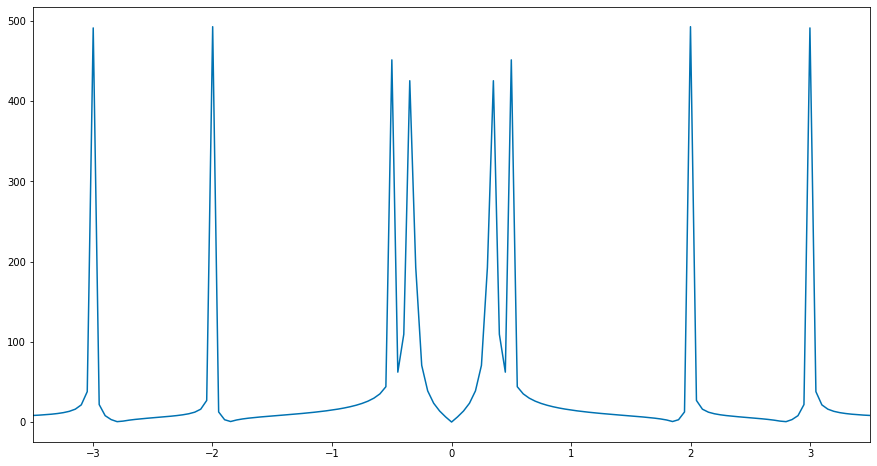

In [5]:
plt.figure(figsize=(15, 8))
plt.xlim(-3.5, 3.5)
plt.plot(freq_x, freq_y);

Now you can notice that the eight peaks are located at exactly the frequencies of the sine waves we used to create the synthetic signal (as well as the corresponding negative values). We can obtain the exact values of all peaks:

In [6]:
from scipy.signal import find_peaks

peaks = find_peaks(freq_y)
peak_coords = freq_x[peaks[0]]
print(peak_coords)

[-2.997003   -1.998002   -0.4995005  -0.34965035  0.34965035  0.4995005
  1.998002    2.997003  ]


Note that the output we are looking at so far is just frequency information (actually, the magnitude of a sine wave component at a particular frequency). There is no phase information in the peaks as they have been plotted. So lets go back to our original synthetic signal and shift our sine waves with respect to the origin.

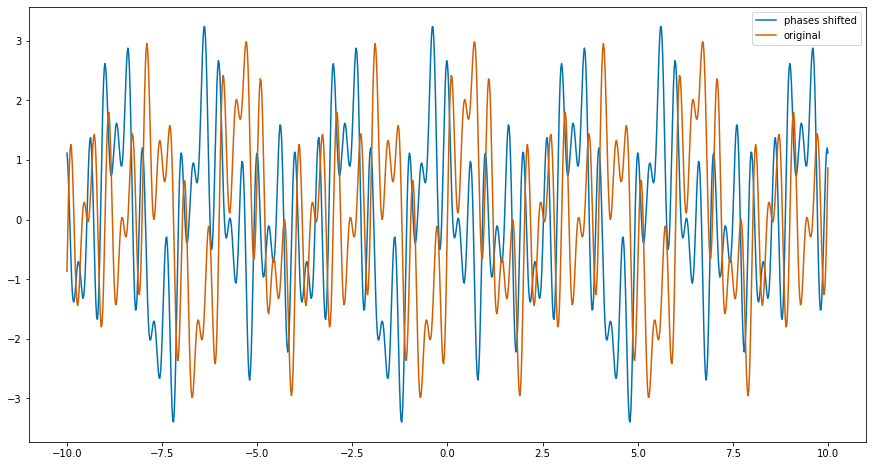

In [7]:
f = [1/3, 1/2, 2, 3]
phase_shifts = [(np.pi * 0.5),(np.pi),(np.pi * 0.3),(np.pi * 0.7)]
y2 = [np.sin((x * freq * (2 * np.pi)) + phase) for freq, phase in zip(f, phase_shifts)] 
y2 = np.sum(y2, axis=0)

# Plot
plt.figure(figsize=(15,8))
plt.plot(x,y2, label='phases shifted')
plt.plot(x,y, label='original', color='C2')
plt.legend();

This signal thus contains the same frequencies as the first example, but those frequencies are phased differently, so the signals look quite different. Now lets take a look at the fourier transform of the phase-shifted example:

[-2.997003   -1.998002   -0.4995005  -0.34965035  0.34965035  0.4995005
  1.998002    2.997003  ]


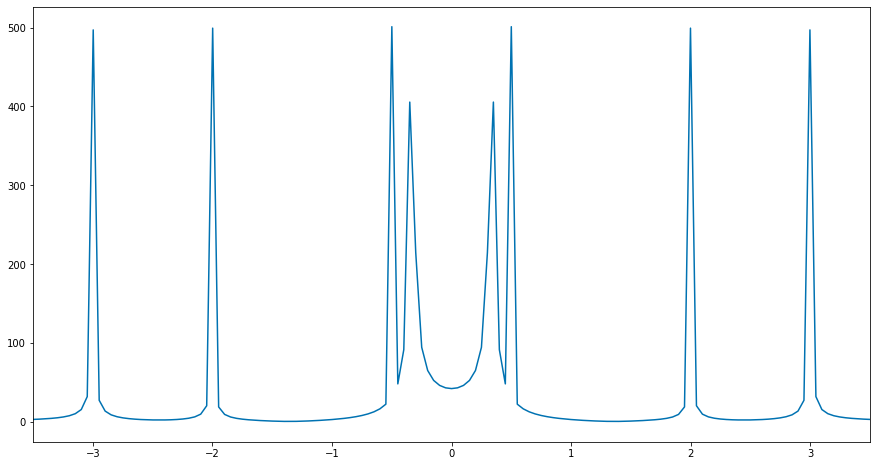

In [8]:
freq_y2 = fftshift(np.abs(fft(y2)))

# Plot
plt.figure(figsize=(15, 8))
plt.xlim(-3.5, 3.5)
plt.plot(freq_x, freq_y2)
peaks2 = find_peaks(freq_y2)
peak_coords2 = freq_x[peaks2[0]]
print(peak_coords2)

As you can see, the FFT gives us the magnitudes of the consituent frequencies of a signal regardless of the phase of those frequencies. Actually, the FFT *also* gives us phase information!

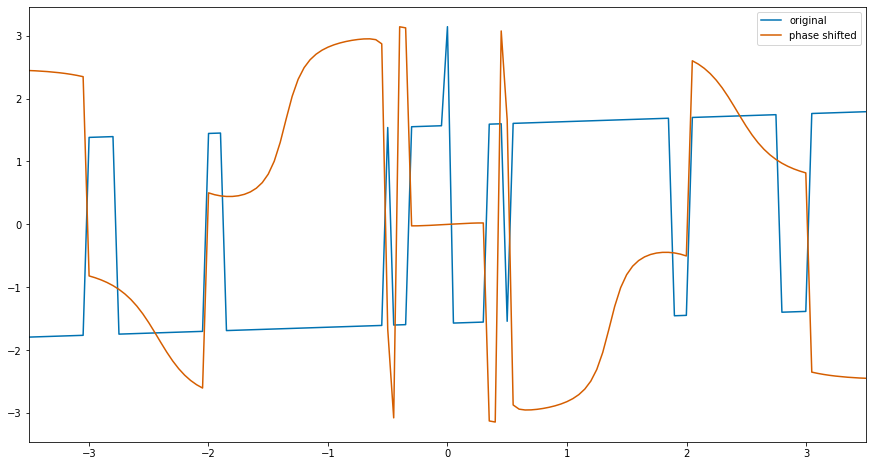

In [9]:
# getting phase information
p = fftshift(np.angle(fft(y)))
p2 = fftshift(np.angle(fft(y2)))

# Plot
plt.figure(figsize=(15, 8))
plt.xlim(-3.5, 3.5)
plt.plot(freq_x, p, label='original')
plt.plot(freq_x, p2, label='phase shifted', color='C2')
plt.legend();

This plot looks a little crazy, but what we really want are the phase values *at the magnitude peaks*.

In [10]:
# negative phase (phase between π and 2π) needs to be converted

phases = []
for w in p[peaks[0]]:
    if w < 0:
        w = 2 * np.pi + w
    phases.append(w)

phases2 = []
for w in p2[peaks2[0]]:
    if w < 0:
        w = 2 * np.pi + w
    phases2.append(w)
    
diffs = np.array(phases2) - np.array(phases)

phase_diffs = []
for w in diffs[4:]: # we only want the positive peaks
    if w < 0:
        w = 2 * np.pi + w
    phase_diffs.append(w)

print('Phases shifts we specified:', phase_shifts)
print('Values returned from FFT:', phase_diffs)

Phases shifts we specified: [1.5707963267948966, 3.141592653589793, 0.9424777960769379, 2.199114857512855]
Values returned from FFT: [1.5675132774469, 3.203684403451479, 0.9439881575977127, 2.2008636435879136]


Notice the values are a bit off. This is expected and shouldn't cause you any concern right now (an explanation requires a bit more math and theory that won't be covered in this lesson). Nonetheless, the information that the FFT *does* return is perfectly sufficient to recreate the original signal:

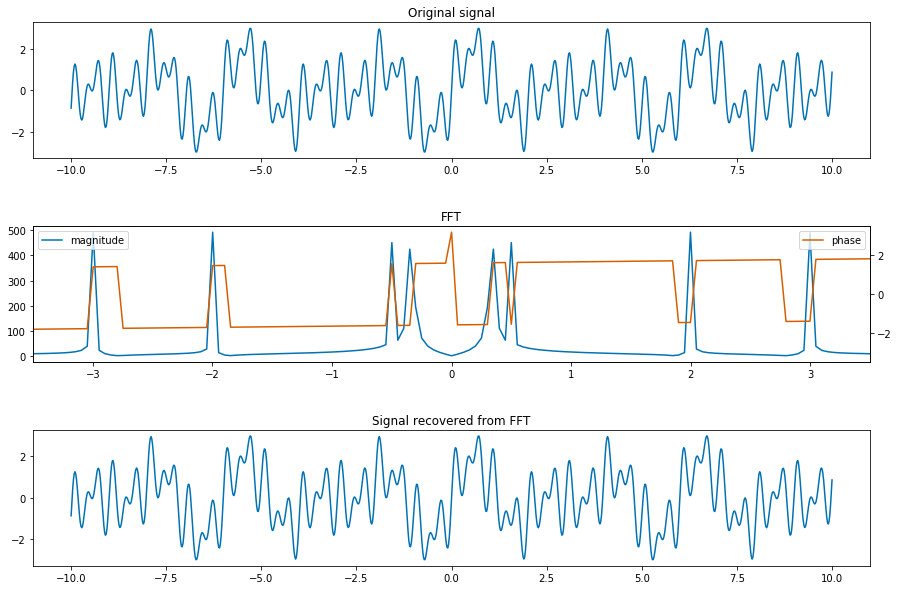

In [13]:
from scipy.fftpack import ifft, ifftshift

y_fft = fftshift(fft(y))
y_from_fft = ifft(ifftshift(y_fft))

# Plot
fig, ax = plt.subplots(nrows=3, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
ax[0].plot(x, y)
ax[0].set_title('Original signal')
ax[1].set_xlim(-3.5, 3.5)
ax[1].plot(freq_x, np.abs(y_fft), label='magnitude')
ax[1].set_title('FFT')
ax[1].legend(loc=2)
ax_share = ax[1].twinx()
ax_share.plot(freq_x, np.angle(y_fft), color='C2', label='phase')
ax_share.legend(loc=1)
ax[2].plot(x, y_from_fft)
ax[2].set_title('Signal recovered from FFT');

At this point you might be wondering why `fftshift`, `np.angle` and `np.abs` are necessary for working with our FFTs. We will go over this shortly. First, lets take a look at a *real* signal to demonstrate the true power of the FFT:

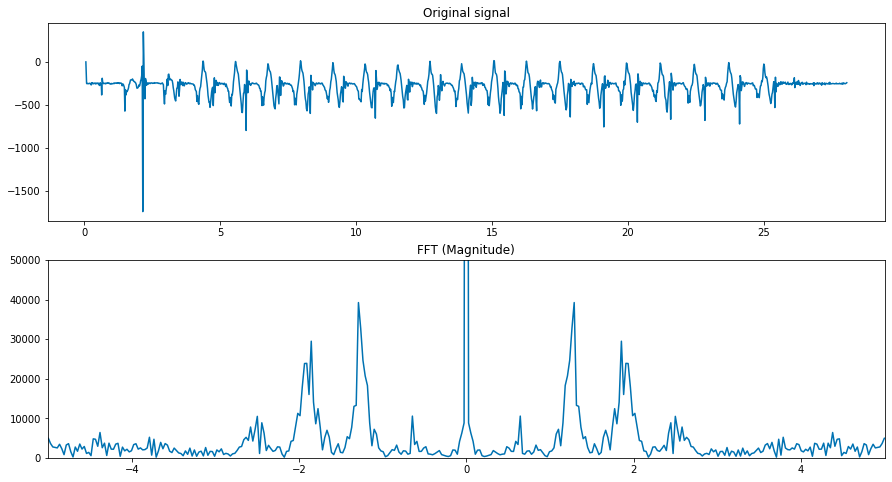

In [31]:
import pandas as pd

# real signal from accelerometer
walk = pd.read_csv('../data/walk1.csv', header = None)
walk.columns = ['x', 'y', 'z', 't']
walk.t = walk.t/1000 # convert ms to s
freq_walk_t = fftshift(fftfreq(walk.t.size, walk.t[1] - walk.t[0]))
x_fft = fftshift(fft(walk.x))


# Plot
fig, ax = plt.subplots(nrows=2, figsize=(15,8))
ax[0].plot(walk.t, walk.x)
ax[0].set_title('Original signal')
ax[1].plot(freq_walk_t, np.abs(x_fft))

# Changing scale on FFT to help see the peaks
# Try playing with the values
ax[1].set_ylim((-10, 50000))
ax[1].set_xlim((-5, 5))
ax[1].set_title('FFT (Magnitude)');

As you have probably guessed by now, FFTs can be used to analyze real signals. This is because *all signals* can be described as a combination of sine waves!

The FFT can thus be used to identify repeating patterns in our real signals. For example, we see that there are peaks of magnitude in the frequency spectrum around 0.75 Hz, 1.5 Hz, 2 Hz and 3 Hz. Looking at the accelerometer signal, this makes sense. There appears to be a repeating pattern that occurs 18 times over 25 seconds (0.72 Hz), with many smaller motions that occur during each cycle.

Now lets take a look at an example of signals taken from an accelerometer during running:

0.72